<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Univariate-Analysis" data-toc-modified-id="Univariate-Analysis-1">Univariate Analysis</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2">Setup</a></span></li><li><span><a href="#Create-simulated-dataset" data-toc-modified-id="Create-simulated-dataset-3">Create simulated dataset</a></span></li><li><span><a href="#Load-post-processed-simulated-data" data-toc-modified-id="Load-post-processed-simulated-data-4">Load post-processed simulated data</a></span></li><li><span><a href="#Visualize-our-data" data-toc-modified-id="Visualize-our-data-5">Visualize our data</a></span></li><li><span><a href="#Perform-group-level-analysis" data-toc-modified-id="Perform-group-level-analysis-6">Perform group-level analysis</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li></ul></div>

# Univariate Analysis

# Setup
Import Python dependencies necessary to run rest of the code.

In [1]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
# change default plotting
plt.rcParams.update({'font.size': 20, 'figure.figsize': (7,2)})

# Create simulated dataset

In [4]:
## Code for simulating the data: ##
import pymc3 as pm
num_subjects = 20
num_conditions = 2
num_voxels = 50
data=[]

normal = pm.Normal.dist(mu=1.5,sigma=.5)
unif = pm.Uniform.dist(lower=-3,upper=3)
ROI = pm.Mixture.dist(w=[.2,.8], comp_dists=[normal,unif])

activations = ROI.random(size=(num_subjects*num_voxels))
sub_id = np.repeat(np.arange(num_subjects),activations.size//num_subjects)
cond_id = np.repeat(0,activations.size)
vox_id = np.tile(np.arange(num_voxels),activations.size//num_voxels)

np.save('activations.npy',activations)

# Load post-processed simulated data
Import our data. Look at how many subjects, trial conditions, and voxels we have to work with. 

Note that we follow Python conventions by numbering variables starting at 0 and not 1.

In [3]:
# allow Python to pull data from GitHub without saving file first
import requests
import io
activations = np.load(io.BytesIO(requests.get('https://my_url/my_np_file.npy').content))

num_subjects = len(np.unique(data['sub_num']))
num_conditions = len(np.unique(data['cond']))
num_voxels = len(np.unique(data['vox']))

print('\n{} Subjects:\n'.format(num_subjects),np.unique(data['sub_num']))
print('\n{} Conditions (0=horror movie, 1=comedy):\n'.format(num_conditions),np.unique(data['cond']))
print('\n{} Voxels:\n'.format(num_voxels),np.unique(data['vox']))

display(data)


20 Subjects:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]

2 Conditions (0=horror movie, 1=comedy):
 [0 1]

100 Voxels:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


,sub_num,cond,vox,beta
0,0,0,0,1.125706
1,0,0,1,0.782892
2,0,0,2,-0.210998
3,0,0,3,0.544258
4,0,0,4,-1.543625
...,...,...,...,...
3995,19,1,95,0.876355
3996,19,1,96,1.880773
3997,19,1,97,-2.156579
3998,19,1,98,2.181628


# Visualize our data

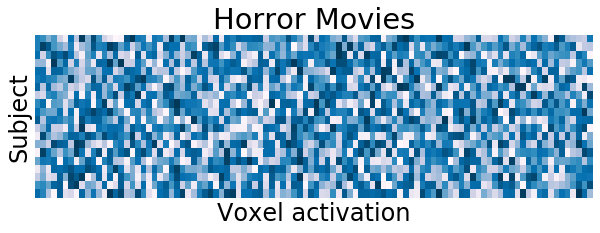

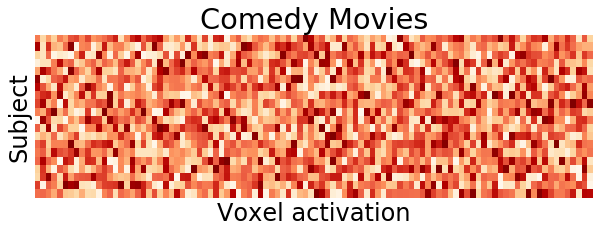

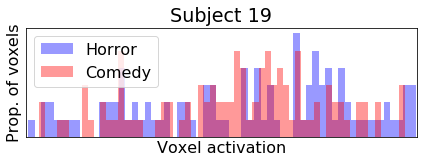

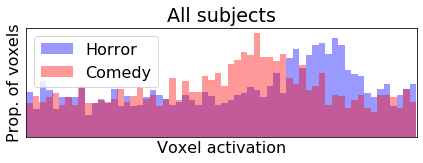

In [97]:
with plt.rc_context(rc={'font.size': 24, 'figure.figsize': (10,3)}):
    sns.heatmap(np.reshape(data[data['cond']==0]['beta'].values,(num_subjects,num_voxels)),
                vmin=-3,vmax=3,cmap="PuBu",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Horror Movies')
    plt.savefig("1a.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

    sns.heatmap(np.reshape(data[data['cond']==1]['beta'].values,(num_subjects,num_voxels)),
                vmin=-3,vmax=3,cmap="OrRd",cbar=False)
    plt.yticks([]);plt.xticks([])
    plt.ylabel('Subject')
    plt.xlabel('Voxel activation')
    plt.title('Comedy Movies')
    plt.savefig("1b.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()
    
with plt.rc_context(rc={'font.size': 16}):
    sns.distplot(data['beta'][(data['cond']==0)&(data['sub_num']==0)],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data['beta'][(data['cond']==1)&(data['sub_num']==0)],bins=60,kde=False,color='r',label="Comedy") 
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.title('Subject 19')
    plt.savefig("2a.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

    sns.distplot(data[data['cond']==0]['beta'],bins=60,kde=False,color='b',label="Horror") 
    sns.distplot(data[data['cond']==1]['beta'],bins=60,kde=False,color='r',label="Comedy") 
    # plt.legend(bbox_to_anchor=(1, 0.5))
    plt.legend()
    plt.ylabel('Prop. of voxels')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.title('All subjects')
    plt.savefig("2b.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

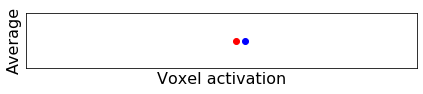

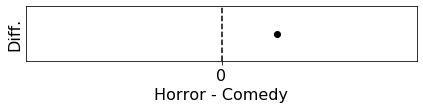

In [92]:
with plt.rc_context(rc={'font.size': 16,'figure.figsize': (7,1)}):
    plt.scatter(np.mean(data['beta'][(data['cond']==0)&(data['sub_num']==0)]),0,color='b',label="Horror") 
    plt.scatter(np.mean(data['beta'][(data['cond']==1)&(data['sub_num']==0)]),0,color='r',label="Comedy") 
    plt.ylabel('Average')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2c.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(np.mean(data['beta'][(data['cond']==0)&(data['sub_num']==0)])+np.mean(data['beta'][(data['cond']==1)&(data['sub_num']==1)]),
                0,color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2d.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

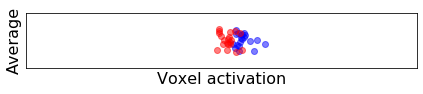

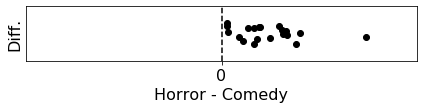

In [93]:
with plt.rc_context(rc={'font.size': 16, 'figure.figsize': (7,1)}):
    jitters = np.random.rand(num_subjects*2)/10
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='b',alpha=.5,label="Horror") 
    plt.scatter(data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[num_subjects:],color='r',alpha=.5,label="Comedy") 
    plt.ylabel('Average')
    plt.xlabel('Voxel activation')
    plt.yticks([]);plt.xticks([])
    plt.xlim([-3,3])
    plt.savefig("2e.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()
    
    plt.scatter(data[data['cond']==0].groupby('sub_num')['beta'].mean()-data[data['cond']==1].groupby('sub_num')['beta'].mean(),
                jitters[:num_subjects],color='k') 
    plt.xlabel('Horror - Comedy')
    plt.ylabel('Diff.')
    plt.axvline(0,color='k',linestyle='--')
    plt.yticks([])
    plt.xticks([0])
    plt.xlim([-1,1])
#     plt.title('Subject 19')
    plt.savefig("2f.png", dpi=250, transparent=True, bbox_inches="tight", format="png")
    plt.show()

# Perform group-level analysis

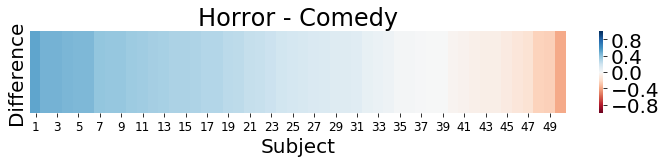

Horror vs. Comedy (paired t-test):
t=5.3904, p=0.0000, d=0.7623


In [110]:
# do statistics between conditions
a=np.mean(np.reshape(data[data['cond']==0]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 0) for every subject
b=np.mean(np.reshape(data[data['cond']==1]['beta'].values,(num_subjects,num_voxels)),
          axis=1) # averaging voxels (in condition 1) for every subject

with plt.rc_context(rc={'figure.figsize': (12,1.5)}):
    sns.heatmap(np.flip(np.sort([a-b])),vmin=-1,vmax=1,cmap="RdBu")
    plt.ylabel("Difference")
    plt.yticks([])
    plt.xticks(np.arange(.5,num_subjects+.5,2), np.arange(1,num_subjects,2), fontsize=12, rotation=0, ha="center")
    plt.xlabel("Subject")
    plt.title("Horror - Comedy")
    plt.savefig("3.png", dpi=250, transparent=True, bbox_inches="tight", pad_inches=0.1, format="png")
    plt.show()

stat = sp.stats.ttest_rel(a,b)
print("Horror vs. Comedy (paired t-test):\nt={:.4f}, p={:.4f}, d={:.4f}".format(
    stat.statistic,stat.pvalue,paired_cohen_d(a,b)))

# Conclusion

**ROI responded more to condition 0 (blue) than condition 1 (red)**